In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('adhd_data.csv')


In [28]:
col_mapping = {
    'Age': 'Yas', 'Gender': 'Cinsiyet', 'Educational_Level': 'Egitim_Seviyesi',
    'Family_History': 'Aile_Gecmisi', 'Sleep_Hours': 'Uyku_Saati',
    'Daily_Activity_Hours': 'Gunluk_Aktivite_Saati', 'Diagnosis_Class': 'Teshis_Sinifi',
    'Daily_Phone_Usage_Hours': 'Gunluk_Telefon_Kullanimi',
    'Daily_Walking_Running_Hours': 'Gunluk_Yuruyus_Kosma',
    'Difficulty_Organizing_Tasks': 'Gorev_Organize_Zorlugu',
    'Focus_Score_Video': 'Video_Odak_Puani',
    'Daily_Coffee_Tea_Consumption': 'Gunluk_Kahve_Cay_Tuketimi',
    'Learning_Difficulties': 'Ogrenme_Guclugu',
    'Anxiety_Depression_Levels': 'Kaygi_Depresyon_Seviyesi'
}
df = df.rename(columns=col_mapping)


q1_cols = [f'Q1_{i}' for i in range(1, 10)]
q2_cols = [f'Q2_{i}' for i in range(1, 10)]

df['Dikkat_Eksikligi_Skoru'] = df[q1_cols].mean(axis=1)
df['Hiperaktivite_Skoru'] = df[q2_cols].mean(axis=1)


le = LabelEncoder()
df['Egitim_Seviyesi'] = le.fit_transform(df['Egitim_Seviyesi'])
df['Aile_Gecmisi'] = le.fit_transform(df['Aile_Gecmisi'])


X = df.drop(columns=['Teshis_Sinifi'] + q1_cols + q2_cols)
y = df['Teshis_Sinifi']

print("--- Yeni Özellik Matrisi (X) İlk 5 Satır ---")
print(X.head())
print("\nKullanılan Özellikler:", X.columns.tolist())

--- Yeni Özellik Matrisi (X) İlk 5 Satır ---
   Yas  Cinsiyet  Egitim_Seviyesi  Aile_Gecmisi  Uyku_Saati  \
0    8         1                3             0           8   
1    9         2                3             0          11   
2    9         1                3             0           9   
3    5         2                0             2           7   
4   13         1                1             0           3   

   Gunluk_Aktivite_Saati  Gunluk_Telefon_Kullanimi  Gunluk_Yuruyus_Kosma  \
0                      7                         2                   0.5   
1                      7                         2                   0.9   
2                      5                         2                   1.4   
3                     11                         6                   0.6   
4                      0                         4                   1.0   

   Gorev_Organize_Zorlugu  Video_Odak_Puani  Gunluk_Kahve_Cay_Tuketimi  \
0                       0                 5  

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Eğitim Seti Boyutu:", X_train_scaled.shape)
print("Test Seti Boyutu:", X_test_scaled.shape)
print("\n--- Ölçeklendirilmiş Veriden Örnek (İlk 2 Satır) ---")
print(X_train_scaled.head(2))

Eğitim Seti Boyutu: (5200, 15)
Test Seti Boyutu: (1300, 15)

--- Ölçeklendirilmiş Veriden Örnek (İlk 2 Satır) ---
        Yas  Cinsiyet  Egitim_Seviyesi  Aile_Gecmisi  Uyku_Saati  \
0 -0.301839  1.239591         0.301291     -0.611612   -0.811023   
1  0.064967  1.239591         0.301291     -0.611612    0.786446   

   Gunluk_Aktivite_Saati  Gunluk_Telefon_Kullanimi  Gunluk_Yuruyus_Kosma  \
0               1.534085                 -1.396713             -0.861443   
1              -1.407702                  0.239691              3.432189   

   Gorev_Organize_Zorlugu  Video_Odak_Puani  Gunluk_Kahve_Cay_Tuketimi  \
0                0.633733         -1.109676                  -0.513018   
1                0.633733         -1.109676                  -0.513018   

   Ogrenme_Guclugu  Kaygi_Depresyon_Seviyesi  Dikkat_Eksikligi_Skoru  \
0        -1.120262                 -1.024317                0.873916   
1         0.892648                  1.821008                0.650880   

   Hiperakti

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SVM": SVC(probability=True, random_state=42, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}


print("--- Modellerin Çapraz Doğrulama Performansı (F1-Weighted) ---")
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='f1_weighted')
    results[name] = cv_scores.mean()
    print(f"{name:20}: %{cv_scores.mean()*100:.2f}")


for name, model in models.items():
    model.fit(X_train_scaled, y_train)

print("\nTüm modeller başarıyla eğitildi!")

--- Modellerin Çapraz Doğrulama Performansı (F1-Weighted) ---
Logistic Regression : %100.00
Decision Tree       : %100.00
Random Forest       : %100.00
SVM                 : %100.00
KNN                 : %97.44
Gradient Boosting   : %99.94

Tüm modeller başarıyla eğitildi!


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


performance_metrics = []

for name, model in models.items():
    
    y_pred = model.predict(X_test_scaled)
    
   
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
   
    performance_metrics.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })


comparison_df = pd.DataFrame(performance_metrics)
comparison_df = comparison_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)


In [24]:
performance_metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    
    performance_metrics.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4),
    })

comparison_df = pd.DataFrame(performance_metrics)
print("--- Analiz Sonuçları  ---")
print(comparison_df.to_string(index=False))


--- Analiz Sonuçları  ---
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    1.0000     1.0000  1.0000    1.0000
      Decision Tree    1.0000     1.0000  1.0000    1.0000
      Random Forest    1.0000     1.0000  1.0000    1.0000
                SVM    0.9992     0.9992  0.9992    0.9992
                KNN    0.9708     0.9713  0.9708    0.9705
  Gradient Boosting    1.0000     1.0000  1.0000    1.0000


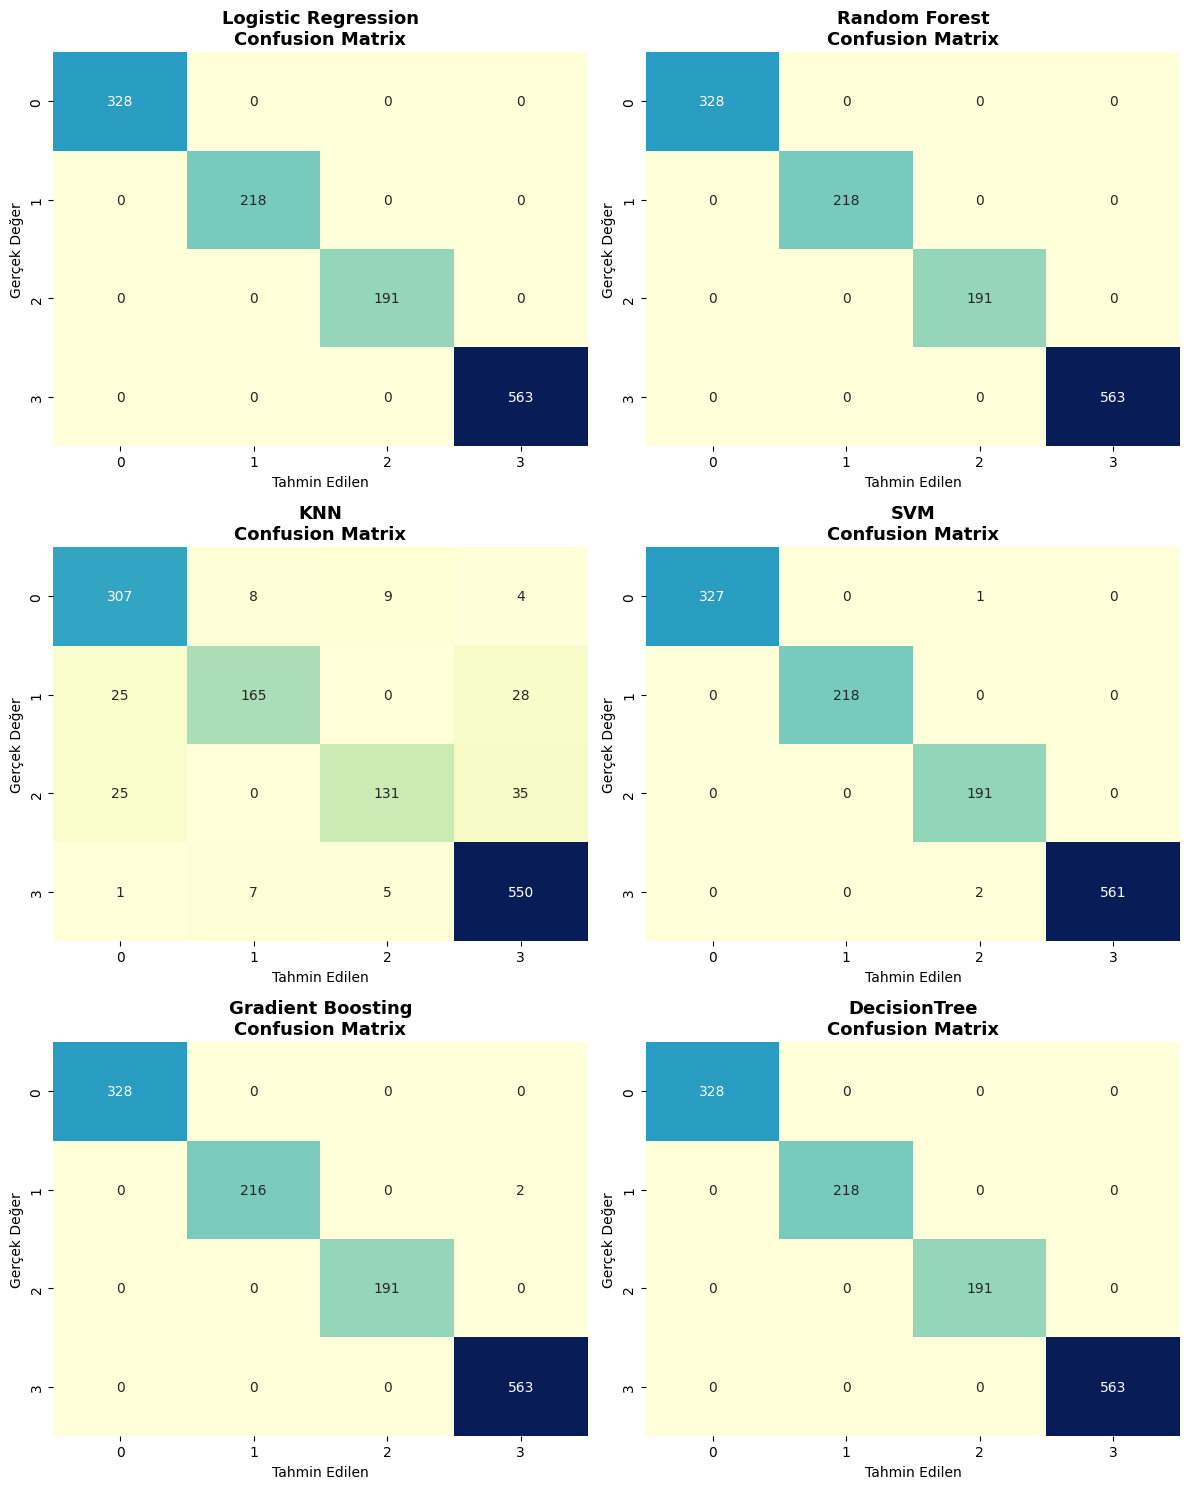

In [42]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


log_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
knn_model = KNeighborsClassifier().fit(X_train, y_train)
svm_model = SVC(probability=True, random_state=42, class_weight='balanced').fit(X_train, y_train)
gbc_model = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced').fit(X_train, y_train)


tum_modellerim = {
    'Logistic Regression': log_model,
    'Random Forest': rf_model,
    'KNN': knn_model,
    'SVM': svm_model,
    'Gradient Boosting': gbc_model,
    'DecisionTree': dt_model
}


sinif_isimleri = sorted(list(set(y_test)))


def plot_all_confusion_matrices(models, X_test, y_test, class_names=None):
    n_models = len(models)
    cols = 2
    rows = math.ceil(n_models / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=axes[i], cbar=False,
                    xticklabels=class_names if class_names else True,
                    yticklabels=class_names if class_names else True)
        axes[i].set_title(f"{name}\nConfusion Matrix", fontsize=13, fontweight='bold')
        axes[i].set_xlabel('Tahmin Edilen')
        axes[i].set_ylabel('Gerçek Değer')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


plot_all_confusion_matrices(tum_modellerim, X_test, y_test, class_names=sinif_isimleri)
